In [1]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("Введите ваш OpenAI API ключ: ")

Введите ваш OpenAI API ключ:  ········


# Импорты

In [14]:
from __future__ import annotations

from dataclasses import dataclass, field, fields
from datetime import UTC, datetime
from typing import (Annotated, Any, Callable, Dict, List, Literal, Optional,
                    Sequence, cast)

import arxiv
from IPython.display import Image
from langchain.chat_models import init_chat_model
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import AIMessage, AnyMessage, BaseMessage
from langchain_core.runnables import ensure_config
from langgraph.config import get_config
from langgraph.graph import StateGraph, add_messages
from langgraph.managed import IsLastStep
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from typing_extensions import Annotated

In [3]:
SYSTEM_PROMPT = """You are a helpful AI assistant."""

# Делаем конфиг для создания агента

In [4]:
"""Define the configurable parameters for the agent."""


@dataclass(kw_only=True)
class Configuration:
    """The configuration for the agent."""

    system_prompt: str = field(
        default=SYSTEM_PROMPT,
        metadata={
            "description": "The system prompt to use for the agent's interactions. "
            "This prompt sets the context and behavior for the agent."
        },
    )

    model: Annotated[str, {"__template_metadata__": {"kind": "llm"}}] = field(
        default="openai/o3-mini",
        metadata={
            "description": "The name of the language model to use for the agent's main interactions. "
            "Should be in the form: provider/model-name."
        },
    )

    max_search_results: int = field(
        default=10,
        metadata={
            "description": "The maximum number of search results to return for each search query."
        },
    )

    @classmethod
    def from_context(cls) -> Configuration:
        """Create a Configuration instance from a RunnableConfig object."""
        try:
            config = get_config()
        except RuntimeError:
            config = None
        config = ensure_config(config)
        configurable = config.get("configurable") or {}
        _fields = {f.name for f in fields(cls) if f.init}
        return cls(**{k: v for k, v in configurable.items() if k in _fields})

# Объявляем state для агента

In [5]:
@dataclass
class InputState:

    messages: Annotated[Sequence[AnyMessage], add_messages] = field(
        default_factory=list
    )


@dataclass
class State(InputState):
    is_last_step: IsLastStep = field(default=False)

# Объявляем вспомогательные функции для агента

In [6]:
class ArxivArticle(BaseModel):
    title: str = Field(description="Заголовок статьи")
    summary: str = Field(description="Краткое содержание статьи")
    pdf_url: str = Field(description="Ссылка на PDF-файл статьи")


def search_arxiv(query: str) -> ArxivArticle:
    search = arxiv.Search(query=query, max_results=1)
    result = next(search.results())

    # Проверяем, есть ли pdf_url
    pdf_url = getattr(result, "pdf_url", None)
    if not pdf_url:
        # Формируем pdf_url вручную из entry_id, если не найден
        entry_id = result.entry_id  # например https://arxiv.org/abs/2301.12345
        # извлечь id из entry_id
        arxiv_id = entry_id.split("/")[-1]
        pdf_url = f"https://arxiv.org/pdf/{arxiv_id}.pdf"

    return ArxivArticle.model_validate(
        {"title": result.title, "summary": result.summary, "pdf_url": pdf_url}
    )


def download_pdf(pdf_url: str) -> str:
    """Скачивает pdf, сохраняет в temp.pdf."""
    r = requests.get(pdf_url)
    with open("temp.pdf", "wb") as f:
        f.write(r.content)
    return "temp.pdf"


def load_pdf(pdf_path: str):
    """Загружает PDF и разбивает на страницы."""
    loader = PyPDFLoader(pdf_path)
    return loader.load_and_split()


class PDFQA:
    """Класс для индексации PDF и ответа на вопросы по ней."""

    def __init__(self):
        self.qa_chain = None

    def index_pdf(self, pages):
        embeddings = OpenAIEmbeddings()
        vectorstore = FAISS.from_documents(pages, embeddings)
        retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
        self.qa_chain = RetrievalQA.from_chain_type(llm=OpenAI(), retriever=retriever)

    def ask(self, question: str) -> str:
        if not self.qa_chain:
            return "PDF не загружен и не проиндексирован."
        return self.qa_chain.run(question)


pdf_qa = PDFQA()


def summarize_pdf(pdf_path: str) -> str:
    pages = load_pdf(pdf_path)
    llm = OpenAI(model_name="o3-mini")
    chain = load_summarize_chain(llm, chain_type="map_reduce")
    summary = chain.run(pages)
    return summary

# Объявляем инструменты для агента

In [7]:
def tool_search_arxiv(query: str) -> str:
    "Поиск статьи в arXiv по запросу. Ввод: поисковый запрос, вывод: title, summary и pdf ссылка."
    return search_arxiv(query)


def tool_load_and_index(pdf_url: str) -> str:
    "Загружает PDF по ссылке, разбивает на страницы и индексирует для поиска."
    pdf_path = download_pdf(pdf_url)
    pages = load_pdf(pdf_path)
    pdf_qa.index_pdf(pages)
    return f"PDF загружен и проиндексирован: {len(pages)} страниц"


def tool_ask_pdf(question: str) -> str:
    "Отвечает на вопросы по загруженному PDF."
    return pdf_qa.ask(question)


def tool_summarize(pdf_url: str) -> str:
    "Делает краткое резюме статьи по PDF-ссылке."
    pdf_path = download_pdf(pdf_url)
    return summarize_pdf(pdf_path)


TOOLS: List[Callable[..., Any]] = [
    tool_search_arxiv,
    tool_load_and_index,
    tool_ask_pdf,
    tool_summarize,
]

In [8]:
def get_message_text(msg: BaseMessage) -> str:
    """Get the text content of a message."""
    content = msg.content
    if isinstance(content, str):
        return content
    elif isinstance(content, dict):
        return content.get("text", "")
    else:
        txts = [c if isinstance(c, str) else (c.get("text") or "") for c in content]
        return "".join(txts).strip()


def load_chat_model(fully_specified_name: str) -> BaseChatModel:
    provider, model = fully_specified_name.split("/", maxsplit=1)
    return init_chat_model(model, model_provider=provider)

In [9]:
def call_model(state: State) -> Dict[str, List[AIMessage]]:
    configuration = Configuration.from_context()

    # Initialize the model with tool binding. Change the model or add more tools here.
    model = load_chat_model(configuration.model).bind_tools(TOOLS)

    # Format the system prompt. Customize this to change the agent's behavior.
    system_message = configuration.system_prompt.format(
        system_time=datetime.now(tz=UTC).isoformat()
    )

    # Get the model's response
    response = cast(
        AIMessage,
        model.invoke([{"role": "system", "content": system_message}, *state.messages]),
    )

    # Handle the case when it's the last step and the model still wants to use a tool
    if state.is_last_step and response.tool_calls:
        return {
            "messages": [
                AIMessage(
                    id=response.id,
                    content="Sorry, I could not find an answer to your question in the specified number of steps.",
                )
            ]
        }

    # Return the model's response as a list to be added to existing messages
    return {"messages": [response]}

#  Строим граф агента

In [10]:
builder = StateGraph(State, input=InputState, config_schema=Configuration)

# Define the two nodes we will cycle between
builder.add_node(call_model)
builder.add_node("tools", ToolNode(TOOLS))

# Set the entrypoint as `call_model`
# This means that this node is the first one called
builder.add_edge("__start__", "call_model")


def route_model_output(state: State) -> Literal["__end__", "tools"]:
    """Determine the next node based on the model's output.

    This function checks if the model's last message contains tool calls.

    Args:
        state (State): The current state of the conversation.

    Returns:
        str: The name of the next node to call ("__end__" or "tools").
    """
    last_message = state.messages[-1]
    if not isinstance(last_message, AIMessage):
        raise ValueError(
            f"Expected AIMessage in output edges, but got {type(last_message).__name__}"
        )
    # If there is no tool call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise we execute the requested actions
    return "tools"


# Add a conditional edge to determine the next step after `call_model`
builder.add_conditional_edges(
    "call_model",
    # After call_model finishes running, the next node(s) are scheduled
    # based on the output from route_model_output
    route_model_output,
)

# Add a normal edge from `tools` to `call_model`
# This creates a cycle: after using tools, we always return to the model
builder.add_edge("tools", "call_model")
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
# Compile the builder into an executable graph
graph = builder.compile(name="ReAct Agent", checkpointer=checkpointer)

In [11]:
config = {"configurable": {"thread_id": "1"}}

#  Примеры запуска

In [12]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "diffusion models 2024",
            }
        ]
    },
    config=config,
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node call_model
================================== Ai Message ==================================
Tool Calls:
  tool_search_arxiv (call_hUWv54yPLUCGMH3xGI8lwe1j)
 Call ID: call_hUWv54yPLUCGMH3xGI8lwe1j
  Args:
    query: diffusion models 2024





/var/folders/t7/0zcbppxn02b4wfhmpbfg0f2m0000gn/T/ipykernel_24844/582665867.py:8: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  result = next(search.results())


Update from node tools
================================= Tool Message =================================
Name: tool_search_arxiv

title="Rebuttal of Morris' criticism of the diffusive compressible Euler model" summary='This short note addresses the criticism of the diffusive compressible Euler\nmodel regarding heat diffusion, sound attenuation and material frame\nindifference put forward by M. Morris.' pdf_url='http://arxiv.org/pdf/2406.18241v1'



Update from node call_model
================================== Ai Message ==================================

I found a paper on arXiv that seems related to diffusion models in the context of fluid dynamics, specifically addressing the diffusive compressible Euler model. Here are the details:

• Title: "Rebuttal of Morris' criticism of the diffusive compressible Euler model"  
• Summary: This work is a short note responding to the criticism raised by M. Morris regarding the diffusive compressible Euler model. The criticism involves aspects su

In [13]:
questions = [
    "Что такое диффузионные модели?",
    "Какие основные результаты в статье?",
    "Какова методология исследования в статье?",
]

for q in questions:
    for chunk in graph.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": q,
                }
            ],
        },
        config=config,
    ):
        for node, update in chunk.items():
            print("Update from node", node)
            update["messages"][-1].pretty_print()
            print("\n\n")

Update from node call_model
================================== Ai Message ==================================

Диффузионные модели – это класс генеративных моделей, использующих процесс диффузии для создания новых данных, таких как изображения, аудио или текст. Основная идея такова:

1. Сначала данные постепенно зашумляются, то есть к ним добавляется случайный шум до тех пор, пока исходная структура почти полностью не теряется.
2. Затем модель обучается выполнять обратный процесс – постепенно устранять шум и восстанавливать исходные данные по шагам. Таким образом, модель генерирует новые примеры, начиная с чистого шума и преобразуя его в осмысленные данные.

Этот подход позволяет моделям получать высококачественные и детализированные результаты, а также обеспечивает стабильность обучения, так как обратный процесс диффузии можно формально описать с помощью стохастических процедур. Диффузионные модели стали особенно популярны в области генерации изображений, где они конкурируют с такими м

# Визуализируем граф

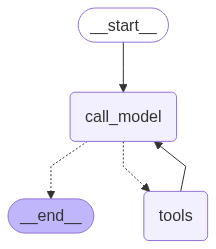

In [15]:
Image(graph.get_graph().draw_mermaid_png())